# BLINK / MatchMS Speed Benchmarking

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, '../')

import blink

import time
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matchms as mms
from matchms.similarity import CosineGreedy, ModifiedCosine

# Load Test Data

In [ ]:
def verify_mz_order(spec):
    """
    verify that mz array is sorted
    """
    is_sorted = np.all(spec[0][:-1] <= spec[0][1:])
    
    return is_sorted

def create_mms_spectra(row):
    """
    create MatchMS formated spectra
    """
    cols = ['name', 'precursor_mz','inchi', 'smiles', 'spectrumid']
    metadata = row[cols].to_dict()
    spectrum = mms.Spectrum(mz=np.array(row['spectrum'][0], dtype="float"), intensities=np.array(row['spectrum'][1], dtype="float"), metadata=metadata)
    
    return spectrum

def generate_sample_spectra(query_size, ref_size, msms_library):
    """
    sample spectra from test library
    """
    query_sample = msms_library.sample(query_size)
    ref_sample = msms_library.sample(ref_size)
    
    return query_sample, ref_sample

def create_mms_spectra(row):
    """
    create MatchMS formated spectra
    """
    cols = ['name', 'precursor_mz','inchi', 'smiles', 'spectrumid']
    metadata = row[cols].to_dict()
    spectrum = mms.Spectrum(mz=np.array(row['spectrum'][0], dtype="float"), intensities=np.array(row['spectrum'][1], dtype="float"), metadata=metadata)
    
    return spectrum

def remove_noise_ions(s):
    """
    remove ions <1% of base peak intensity 
    """
    s_ratio = s[1] / s[1].max()
    idx = s_ratio > 0.01
    s_clean = np.array([s[0][idx], s[1][idx]])
    
    return s_clean

def filter_spectra(row, decimal=3):
    """
    filter noise ions and round m/z values to a consistent decimal place
    """
    idx = np.argwhere(abs(row['spectrum'][0]-row['precursor_mz'])>14).flatten()
    s = row['spectrum'][:,idx]
    s_filtered = s.round(decimal)
    
    return s_filtered

def round_precursor_mz(row, decimal=3):
    """
    round precursor m/z 
    """
    r_pmz = round(row['precursor_mz'], decimal)
    
    return r_pmz

In [ ]:
gnps_all = blink.open_msms_file('/global/cfs/cdirs/metatlas/projects/spectral_libraries/ALL_GNPS_20221017.mgf')

#remove incorrectly sorted spectra and spectra with small precursor mzs
gnps_all['is_sorted'] = gnps_all.spectrum.apply(verify_mz_order)
gnps_all = gnps_all[gnps_all.is_sorted == True]
gnps_all = gnps_all[gnps_all.precursor_mz > 60]

#remove all zero intensity ions
gnps_all.spectrum = blink.filter_spectra(gnps_all.spectrum, gnps_all.precursor_mz)

#remove fragment ions greater than precursor mz and round values consistently
gnps_all.spectrum = gnps_all.apply(lambda x: filter_spectra(x), axis=1)

#remove empty spectra
gnps_all['spec_size'] = gnps_all.spectrum.apply(lambda x: len(x[1]))
gnps_all = gnps_all[gnps_all.spec_size > 0]

#remove ions less than 1% of base peak intensity for higher quality scores
gnps_all.spectrum = gnps_all.spectrum.apply(remove_noise_ions)

# Speed Comparison

### Define Speed Benchmarking Parameters

In [ ]:
replicate = 3

#Loop parameters
iteration_num = 7
multiplier = 10
initial_query_size = 10
initial_ref_size = 10

#MatchMS parameters
cos = CosineGreedy(tolerance=0.00099, intensity_power=0.5)
mod = ModifiedCosine(tolerance=0.00099, intensity_power=0.5)

#BLINK parameters
bin_width = 0.0001
tolerance = 0.001

### Compute Comparison

In [ ]:
index = 0
iteration = 1
multiplier_sqrt = math.sqrt(multiplier)

speed_test_results = {'query_spectra_num':{}, 'ref_spectra_num':{}, 'blink_time':{}, 'mms_time':{}, 'replicate':{}}
query_size = initial_query_size
ref_size = initial_ref_size

while iteration <= iteration_num: 
    
    print("iteration {iteration} of {iteration_num} start".format(iteration=iteration, iteration_num=iteration_num))

    query_sample, ref_sample = generate_sample_spectra(query_size, ref_size, gnps_all)

    S1 = blink.discretize_spectra(query_sample.spectrum,  query_sample.precursor_mz,  intensity_power=0.5, calc_network_score=False, bin_width=bin_width)
    S2 = blink.discretize_spectra(ref_sample.spectrum, ref_sample.precursor_mz, intensity_power=0.5, calc_network_score=False, bin_width=bin_width)

    MMS1 = query_sample.apply(lambda x: create_mms_spectra(x), axis=1)
    MMS2 = ref_sample.apply(lambda x: create_mms_spectra(x), axis=1)

    t0 = time.time()
    S12 = blink.score_sparse_spectra(S1, S2, tolerance=tolerance, calc_network_score=False)
    t1 = time.time()

    blink_time = t1 - t0

    t2 = time.time()
    MMS12 = cos.matrix(references=MMS1, queries=MMS2)
    t3 = time.time()

    mms_time = t3 - t2

    speed_test_results['query_spectra_num'][index] = query_size
    speed_test_results['ref_spectra_num'][index] = ref_size
    speed_test_results['replicate'][index] = replicate
    speed_test_results['blink_time'][index] = blink_time
    speed_test_results['mms_time'][index] = mms_time

    query_size = round(query_size * multiplier_sqrt)
    ref_size = round(ref_size * multiplier_sqrt)

    print("iteration {iteration} of {iteration_num} end".format(iteration=iteration, iteration_num=iteration_num))
    
    if iteration == iteration_num:
        with open('blink_scores_replicate0{num}.pickle'.format(num=replicate), 'wb') as output_file:
            pickle.dump(S12, output_file, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open('mms_scores_replicate0{num}.pickle'.format(num=replicate), 'wb') as output_file:
            pickle.dump(MMS12, output_file, protocol=pickle.HIGHEST_PROTOCOL)

    index += 1
    iteration += 1

df = pd.DataFrame.from_dict(speed_test_results, orient='columns')
df['comparisons'] = df['query_spectra_num'] * df['ref_spectra_num']

### Save & Plot Results

In [ ]:
plot_df = df.groupby('comparisons')[['blink_time', 'mms_time']].median()
plot_df.reset_index(inplace=True)

plt.plot(plot_df['comparisons'], plot_df['blink_time'], '-o', label='BLINK')
plt.plot(plot_df['comparisons'], plot_df['mms_time'], '-o', label='MatchMS')

plt.ylabel('Compute Time (seconds)')
plt.xlabel('# Comparisons')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
df.to_csv('cos_speed_benchmarking_replicate0{num}.csv'.format(num=replicate))

# Merge Replicates & Generate Final Speed Plot

In [2]:
rep1 = pd.read_csv('cos_speed_benchmarking_replicate01.csv', index_col=0)
rep2 = pd.read_csv('cos_speed_benchmarking_replicate02.csv', index_col=0)
rep3 = pd.read_csv('cos_speed_benchmarking_replicate03.csv', index_col=0)

final_df = pd.concat([rep1, rep2, rep3])

In [3]:
final_df = final_df[final_df.comparisons >= 1500]

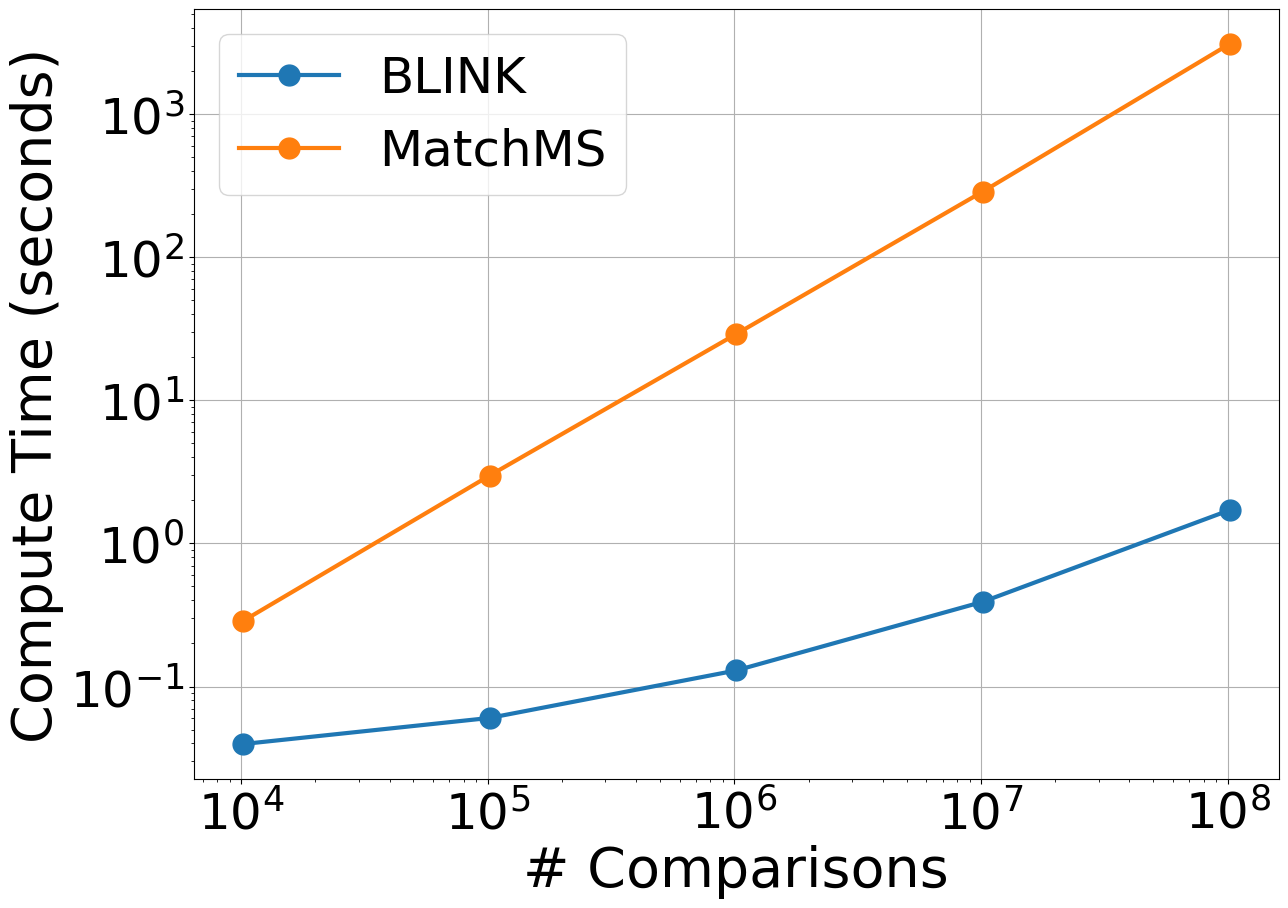

In [4]:
plot_df = final_df.groupby('comparisons')[['blink_time', 'mms_time']].median()
plot_df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(14,10))
ax.plot(plot_df['comparisons'].values, plot_df['blink_time'].values, '-o', label='BLINK', linewidth=3, markersize=15)
ax.plot(plot_df['comparisons'].values, plot_df['mms_time'].values, '-o', label='MatchMS', linewidth=3, markersize=15)

plt.ylabel('Compute Time (seconds)', fontsize=40)
plt.xlabel('# Comparisons', fontsize=40)
ax.tick_params(axis='both', labelsize=36)
ax.tick_params(axis='both', labelsize=36)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.legend(loc=2, prop={'size': 36})
plt.grid()
plt.show()

fig.savefig('cos_speed_benchmark.pdf')

# Load Scores and Generate Final Agreement Matrix

In [5]:
with open('blink_scores_replicate01.pickle', 'rb') as input_file:
    S12 = pickle.load(input_file)
    
with open('mms_scores_replicate01.pickle', 'rb') as input_file:
    MMS12 = pickle.load(input_file)

In [6]:
#filter scores using GNPS default
good_score = 0.7
good_matches = 6

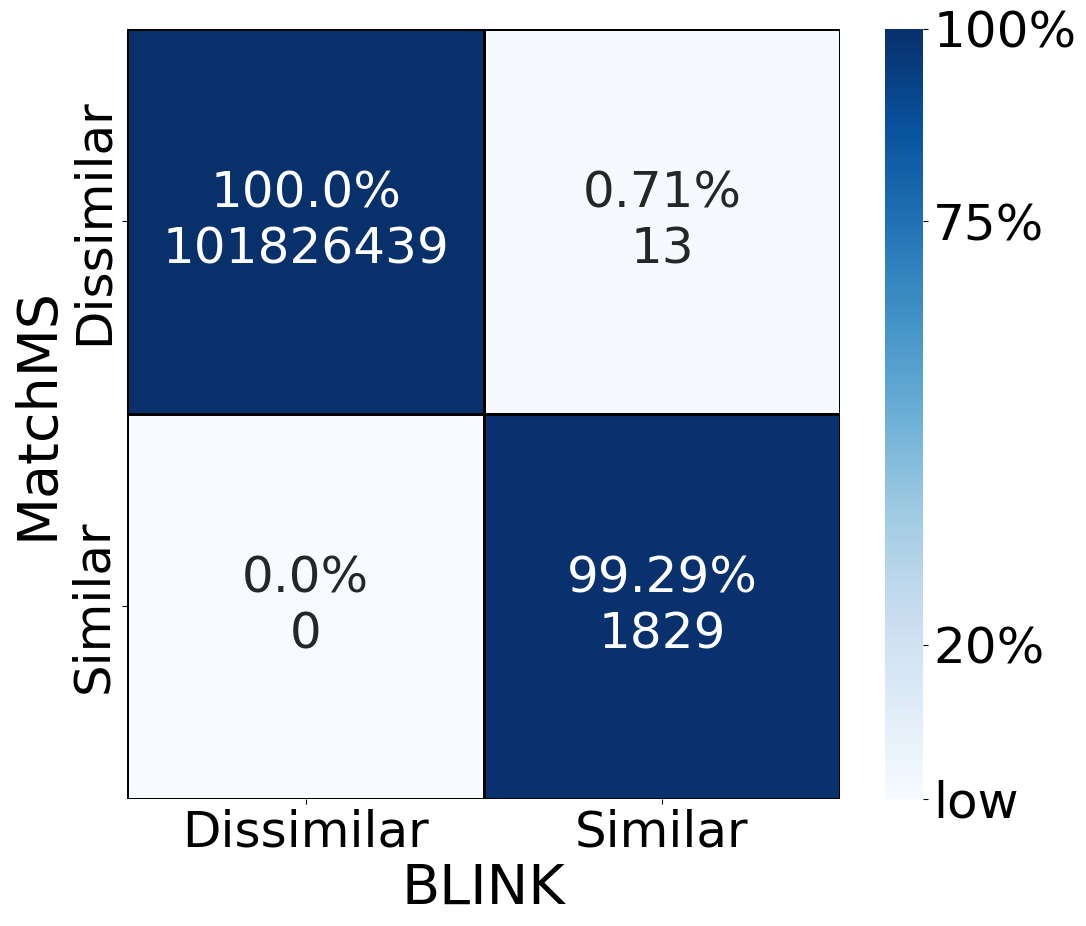

In [7]:
idx1 = S12['mzi'].toarray().flatten()>=good_score
idx2 = S12['mzc'].toarray().flatten()>=good_matches

idx3 = MMS12['score'].flatten()>=good_score
idx4 = MMS12['matches'].flatten()>=good_matches

blink_ids = idx1 * idx2
matchms_ids = idx3 * idx4

# cm_norm = confusion_matrix(matchms_ids, blink_ids, normalize='pred')
cm = confusion_matrix(matchms_ids, blink_ids)
cm_norm = cm / cm.astype(float).sum(axis=0)
df = pd.DataFrame(cm)

# perc = df.copy()
# cols=perc.columns.values
# perc[cols]=perc[cols].div(perc[cols].sum(axis=1), axis=0).multiply(100)
perc = pd.DataFrame(data=cm_norm * 100)
annot = perc.round(2).astype(str) + "%" + "\n" + df.round(2).astype(str) 

fig, ax = plt.subplots(figsize=(11.5, 10))
ax = sns.heatmap(cm_norm, annot=annot, fmt='', vmin=0, vmax=1, cmap="Blues", 
            annot_kws={"fontsize":36}, linewidth=1,linecolor='black' ,xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'])

ax.tick_params(labelsize=36)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=36)
cbar.set_ticks([0, .2, .75, 1])
cbar.set_ticklabels(['low', '20%', '75%', '100%'])

plt.xlabel('BLINK', fontsize=40)
plt.ylabel('MatchMS', fontsize=40)
plt.show()

fig.savefig('cos_confusion_matrix.pdf')

# Median Score and Count Differences of True Positives

In [8]:
c = np.logical_and(blink_ids, matchms_ids)

blink_scores = S12['mzi'].toarray().flatten()
blink_counts = S12['mzc'].toarray().flatten()
mms_scores = MMS12['score'].flatten()
mms_counts = MMS12['matches'].flatten()

blink_nonzero = blink_scores > 0
mms_nonzero = mms_scores > 0

# mean_score_diff = np.mean(blink_scores[blink_nonzero] - mms_scores[mms_nonzero])
# mean_count_diff = np.mean(blink_counts[blink_nonzero] - mms_counts[mms_nonzero])

mean_score_diff = np.mean(blink_scores[c] - mms_scores[c])
mean_count_diff = np.mean(blink_counts[c] - mms_counts[c])
print("mean BLINK score difference: +{mean_score_diff}".format(mean_score_diff=mean_score_diff))
print("mean BLINK count difference: +{mean_count_diff}".format(mean_count_diff=mean_count_diff))

mean BLINK score difference: +0.00040210559078374683
mean BLINK count difference: +0.05522143247676326
